In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [5]:
# First calibrate the camera. 
# image = mpimg.imread('camera_cal/calibration2.jpg')

images = glob.glob('camera_cal/calibration*.jpg')


## 9 x 6 chessboards are considered for the calibration of the camera. 
nx = 9
ny = 6

objpoints = []
imgpoints = []

for image_name in images:
    image = mpimg.imread(image_name)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    objp = np.zeros((6*9,3),np.float32)
    objp[ :, :2 ] = np.mgrid[0:9, 0:6].T.reshape( -1, 2)
    
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(image, (nx,ny), corners, ret)


The original image is: 


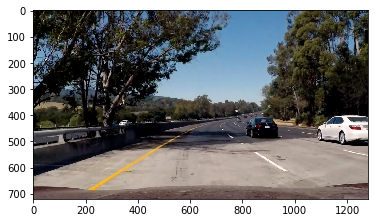

The undistorted Image is: 


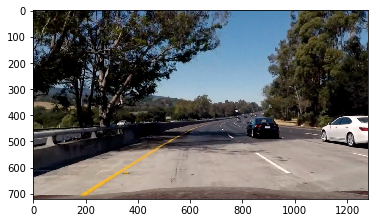

In [6]:
# Test image for the function undistortion

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
test_image = mpimg.imread('test_images/test5.jpg')
print("The original image is: ")
plt.imshow(test_image)
plt.show()
print("The undistorted Image is: ")
undist = cv2.undistort(test_image, mtx, dist, None, mtx)
plt.imshow(undist)
plt.show()

def undistort(image):
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undist_image

In [7]:
# Simple - Extract the images S channel and apply the thresholding. 

def edges(image):
    # HLS Conversion
    image_hls = cv2.cvtColor( image, cv2.COLOR_RGB2HLS)
    
    # Gray scale conversion
    gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY )
    
    # Threshold values for the gradient image
    thresh = [20,100]
    
    # Threshold values for the S channel thresholding. 
    threshS = [170,255]
    
    S = image_hls[:,:,2]
    
    binary_image_cc = np.zeros_like(S)
    binary_image_cc[(S>threshS[0])&(S<threshS[1])]=1

    ## Application of the sobel operator in the x direction. 
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>thresh[0])&(scaled_sobel<thresh[1])]=1
    
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, binary_image_cc ))
    final_img = np.zeros_like(sxbinary)
    final_img[(binary_image_cc==1)|(sxbinary==1)]=1
    return final_img

In [8]:
# Apply the perspective transform to the image. Take the trapezoidal zone and do that

def warp(final_image): 
#    The coordinates used as the source points
    src = np.float32([[700,450],[1150,719],[200,719],[600,450]])
#    The coordinates used as the destination points
    dst = np.float32([[980,0],[980,719],[375,719],[375,0]])
#     For perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
#     For inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_shape = ( final_image.shape[1], final_image.shape[0])
    warped = cv2.warpPerspective( final_image, M, img_shape , flags=cv2.INTER_LINEAR)
    return warped, M, Minv
    

In [52]:
# Identify the lane line pixels and fit with a polynomial.
value = 1
def findLaneLines(warped, Minv):
    global left_fit
    global right_fit
    global value
    
#     Histogram of the image. 
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis = 0)
    out_img = np.dstack((warped, warped, warped))*255
    
# The below steps are to identify the lane lines. The lines are present where there are peaks in the hisotgram.
# The peaks are identified using the np.argmax function in the left half of the image and in the right half of the image. 
    mid = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:mid])
    rightx_base = np.argmax(histogram[mid:])+mid

    nonzeros = warped.nonzero()
    nonzeroy = np.array(nonzeros[0])
    nonzerox = np.array(nonzeros[1])
#     Margin for the search window. 
    margin = 100
    minpix = 50
    
    ## This is to identify the initial the first frame. From the next frame, we reduce the search space. 
    if(value==1):
        windows = 9
        window_height = np.int(warped.shape[0])/windows
        
        leftx_curr  = leftx_base
        rightx_curr = rightx_base
        
        left_lane_inds = []
        right_lane_inds = []

        for window in range(windows):
            win_y_low       = np.int(warped.shape[0] - (window+1)*window_height)
            win_y_high      = np.int(warped.shape[0] - (window)*window_height)
            win_xleft_low   = np.int(leftx_curr - margin)
            win_xleft_high  = np.int(leftx_curr + margin)
            win_xright_low  = np.int(rightx_curr - margin)
            win_xright_high = np.int(rightx_curr + margin)
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

            good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)


            if len(good_left_inds) > minpix:
                leftx_curr = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_curr = np.int(np.mean(nonzerox[good_right_inds]))


        left_lane_inds  = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
#     All the points in the left window and the right window are identified. 
        leftx  = nonzerox[left_lane_inds]
        lefty  = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
# A second degree polynomial is fit for the points identified above in the left window and right window. 
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        binary_warped = warped
        
#  To identify the points on the line, an array of points in the y dimension are taken.
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
#  To identify the corresponding X points, the left_fit and the right_fit calculated above are used.        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#  
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        window_img = np.zeros_like(out_img)

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1  = np.array([ np.transpose(np.vstack([ left_fitx - margin , ploty]))])
        left_line_window2  = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts      = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        value = 2
        
        return left_fitx, right_fitx, ploty, left_fit, right_fit
    
    else:
        binary_warped = warped
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        return left_fitx, right_fitx, ploty, left_fit, right_fit

In [53]:
radiuses = []
def find_curv(left_fitx, right_fitx, ploty, left_fit,right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    global radiuses
    radiuses.append([left_curverad, right_curverad])
    
#     print ('Left curvature: ',left_curverad,' Right curvature: ', right_curverad)

In [54]:
# Create an image to draw the lines on
import functools

history = []

def unwarp_image(undist, warped, Minv, left_fitx, ploty, right_fitx):
    
    global history
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left  = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
#     if(len(history)>=7):
#         history = history[1:]
#         history.append(color_warp[:,:,1])
#     else:
#         history.append(color_warp[:,:,1])
    
#     if(len(history)<7):
#         color_warp = functools.reduce(lambda a, b: a+b, history)/float(len(history))
#     else:
#         color_warp = functools.reduce(lambda a, b: a+b, history)/7.0
    
#     color_warp2 = np.dstack((warp_zero, color_warp, warp_zero)).astype(np.uint8)
#     print('color_warp2 shape is: ',color_warp2.shape)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result



In [67]:

def process_image(image):
    
    image = undistort(image)
    image_edges = edges(image)
    plt.imshow(image_edges, cmap = 'Greys_r')
    plt.show()
    imageWarped, M, Minv = warp(image_edges)
    plt.imshow(imageWarped, cmap = 'Greys_r')
    plt.show()
    leftFitX, rightFitX, plotY, leftFit, rightFit = findLaneLines(imageWarped, Minv)
    find_curv( leftFitX, rightFitX, plotY, leftFit, rightFit)
    final_image = unwarp_image(image, imageWarped, Minv, leftFitX, plotY,rightFitX)
    return final_image
    

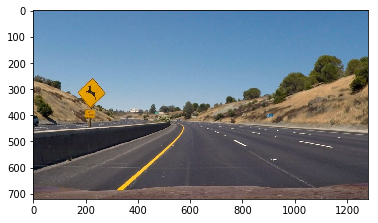

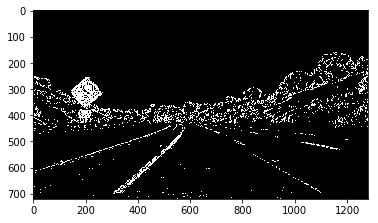

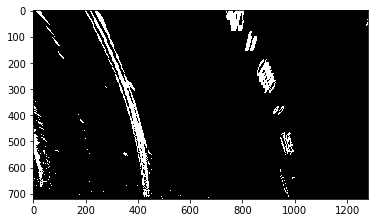

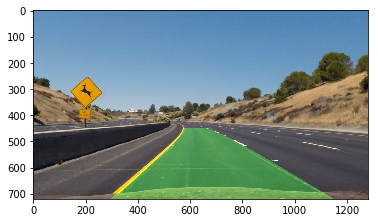

In [68]:
im = mpimg.imread('test_images/test2.jpg')
plt.imshow(im)
plt.show()
plt.imshow(process_image(im))
plt.show()


In [57]:
# Testing on Videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [58]:
white_output = 'project.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=True)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing audio in projectTEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:01<00:00, 692.35it/s]

[MoviePy] Done.
[MoviePy] Writing video project.mp4



100%|█████████▉| 1260/1261 [07:21<00:00,  3.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 9min 25s, sys: 32.2 s, total: 9min 58s
Wall time: 7min 24s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))